In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
%matplotlib inline  
from IPython.display import FileLink, FileLinks


In [87]:
df = pd.read_csv('./pilot.csv')
df['logs'] = df['logs'].map(lambda x: json.loads(x) if not pd.isnull(x) else pd.NA)

df.loc[df['participant_id'].isna(),'participant_id'] = 'test'
df['__INDEX__'] = df['__INDEX__'].map(json.loads)

df.loc[df['participant_id'] == 'arnav','participant_id'] = 1
df.loc[df['participant_id'] == 'karthik','participant_id'] = 2
df.loc[df['participant_id'] == 'majeed','participant_id'] = 3

def find_start(x):
    if type(x) != list:
        return pd.NA
    
    for log in x:
        if log['type'] == 'START':
            return log['timestamp']
    
    return pd.NA

def find_end(x):
    if type(x) != list:
        return pd.NA
    for log in x:
        if log['type'] == 'END':
            return log['timestamp']
    
    return pd.NA


def extract_metadata(x):
#     print(pd.Series(json.loads(x['metadata'])))
    d = json.loads(x['metadata'])
    if 'participant_id' in d:
        del d['participant_id']
    return pd.Series(d)
    

df['start'] = df['logs'].map(find_start)
df['end'] = df['logs'].map(find_end)
# df = df.apply(find_random_pid, axis=1)
df = pd.concat([df, df.apply(extract_metadata, axis=1)], axis=1)


In [94]:
def rename_participants(x):
#     print(x['participant_id'])
#     print(pd.isna(x['participant_id']))
    
    if pd.isna(x['participant_id']) or x['participant_id'] == 'unknown':
        x['participant_id'] = x['participant']
    return x
df = df.apply(rename_participants, axis=1)

In [34]:
gdf = df.groupby(['participant_id']).agg({'start' : 'min', 'end' : 'max'}).reset_index()
gdf['duration'] = gdf['end'] - gdf['start']
gdf['duration'] / 1000 / 60

0    22.439333
1     9.128367
2    19.441400
3    49.826517
Name: duration, dtype: float64

# Dataframe Creation

## Selection

In [95]:
selection = df[df['task'] == 'CommandSelection'].copy()


def extract_selection(row):
    errors = 0
    start = None
    end = None
    for log in row['logs']:
        if log['type'] == 'WRONG_COMMAND':
            errors += 1
        if log['type'] == 'START':
            start = log['timestamp']
        if log['type'] == 'END':
            end = log['timestamp']
    row['errors'] = errors
    row['has_error'] = errors > 0
    row['duration_milliseconds'] = end - start
    row['duration_minutes'] = row['duration_milliseconds'] / 1000 / 60

    return row
selection['trial'] = selection['__INDEX__'].map(lambda x: x[2])
selection['trial_total'] = selection['__INDEX__'].map(lambda x: x[0] * x[1])

selection = selection[['participant_id', '__INDEX__', 'logs', 'command', 'trial','trial_total', 'menu']]

selection = selection.apply(extract_selection, axis=1)


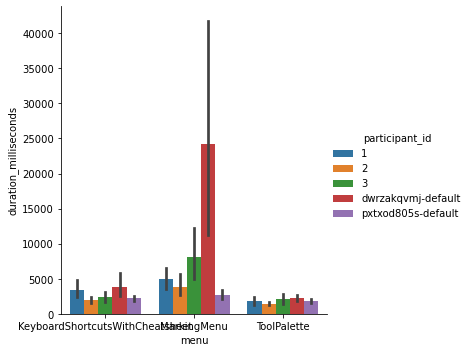

In [98]:
sns.catplot(data=selection, kind="bar", x='menu', y='duration_milliseconds', hue='participant_id')

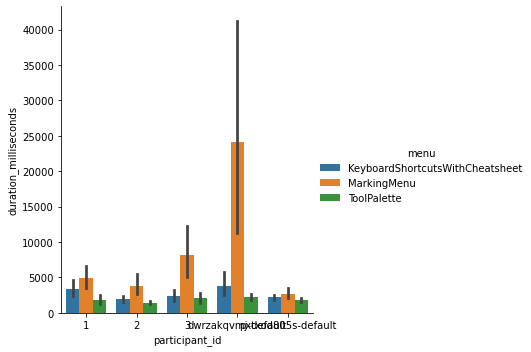

In [99]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='duration_milliseconds', hue='menu')

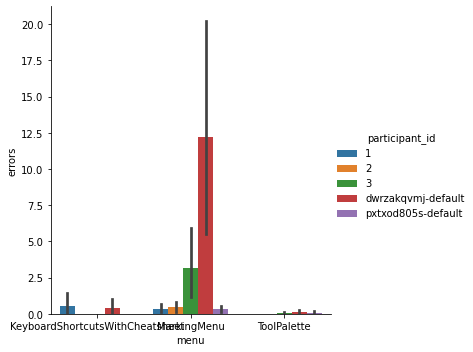

In [100]:
sns.catplot(data=selection, kind="bar", x='menu', y='errors', hue='participant_id')

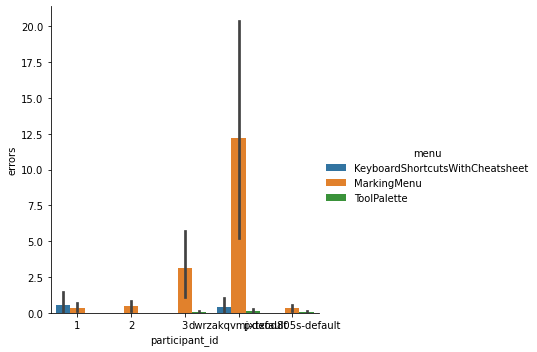

In [101]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='errors', hue='menu')

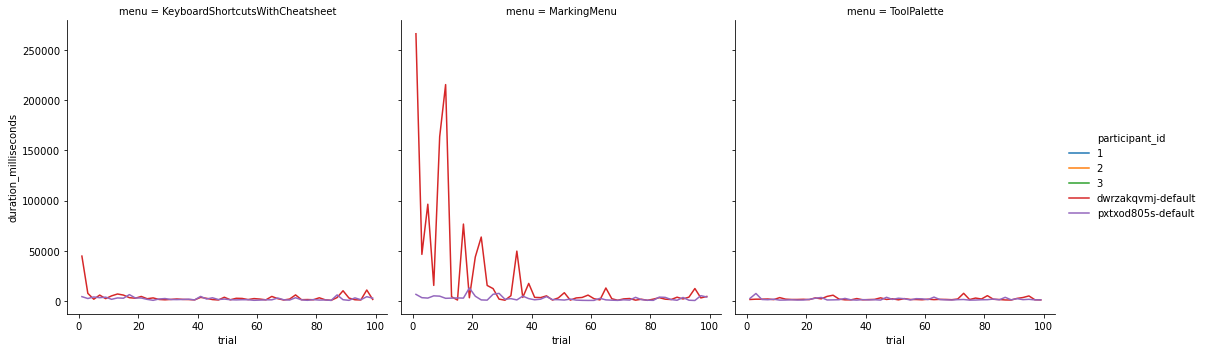

In [102]:
sns.relplot(data=selection,kind='line', x='trial', y='duration_milliseconds', hue='participant_id', col="menu")

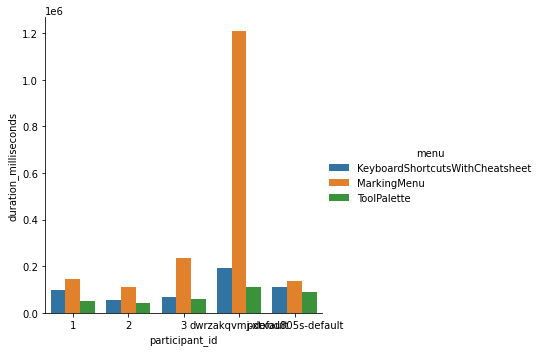

In [103]:
sns.catplot(data=selection.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='participant_id', y='duration_milliseconds', hue='menu')

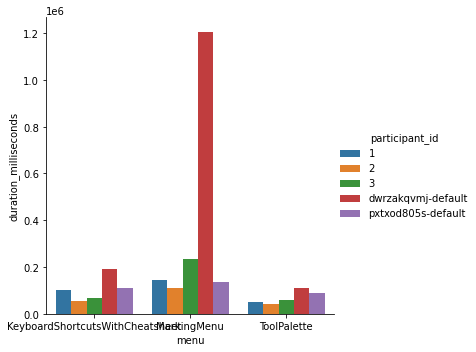

In [104]:
sns.catplot(data=selection.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='menu', y='duration_milliseconds', hue='participant_id')

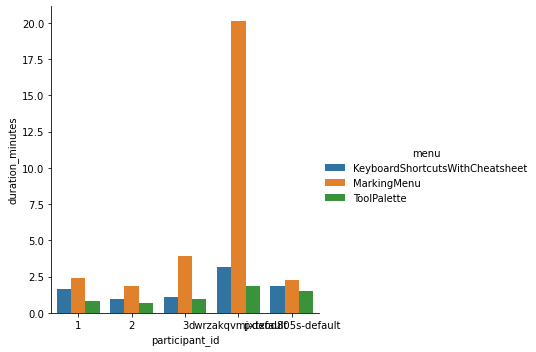

In [105]:
sns.catplot(data=selection.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='participant_id', y='duration_minutes', hue='menu')

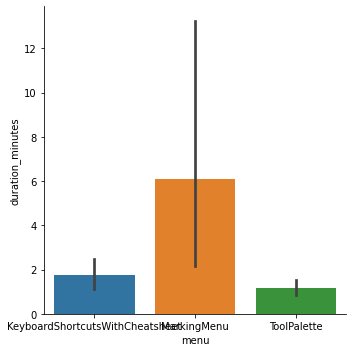

In [106]:
sns.catplot(data=selection.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='menu', y='duration_minutes')

## Creativity

In [129]:
unusual_uses = df[df['task'] == 'DivergentTest'].copy()

unusual_uses.fillna({'menu':'baseline'}, inplace=True)

# TODO: so the issue here is that we have multiple rows per group.

def extract_unusual_uses(g):
    for index, row in g.iterrows():
        if not isinstance(row['logs'], list):
            return pd.Series(pd.NA)

        for log in row['logs']:
            if log['type'] == 'DivergentTest':
                new_df = pd.DataFrame(log['values'], columns=['values'])
                new_df['topTwo'] = False
                # TODO: just need to pad the Nones with some falses to make things worlk

                new_df.loc[list(map(bool, log['topTwo'])) + [False] * (len(log['values']) - len(log['topTwo'])), 'topTwo'] = True
                return new_df
        
unusual_uses = unusual_uses.groupby(['participant_id', 'menu', 'object']).apply(extract_unusual_uses).reset_index()
del unusual_uses['level_3']
# del unusual_uses[0]

In [130]:
unusual_uses

,participant_id,menu,object,values,topTwo
0,1,KeyboardShortcutsWithCheatsheet,shoe,as a hat,False
1,1,KeyboardShortcutsWithCheatsheet,shoe,as a tennis ball,True
2,1,KeyboardShortcutsWithCheatsheet,shoe,as a computer,False
3,1,KeyboardShortcutsWithCheatsheet,shoe,as a house to live in,False
4,1,KeyboardShortcutsWithCheatsheet,shoe,as a toy,False
...,...,...,...,...,...
107,pxtxod805s-default,baseline,shoe,You can use the strings to tie up anything you...,False
108,pxtxod805s-default,baseline,shoe,Put them on the feet of tables or chairs to pr...,True
109,pxtxod805s-default,baseline,shoe,Use them as a soft mallet to strike items that...,False
110,pxtxod805s-default,baseline,shoe,Put them underneath barbells to keep them from...,False


In [131]:
unusual_uses[unusual_uses['topTwo']].to_csv('./toptwo.csv', index=False)
display(FileLink('./toptwo.csv'))
unusual_uses[unusual_uses['topTwo']]

/Users/blainelewis/research/creativity-experiment/analysis/toptwo.csv

,participant_id,menu,object,values,topTwo
1,1,KeyboardShortcutsWithCheatsheet,shoe,as a tennis ball,True
11,1,KeyboardShortcutsWithCheatsheet,shoe,to collect seasoning off the ground,True
20,1,MarkingMenu,knife,as a research companion to talk to,True
22,1,MarkingMenu,knife,as a lightning rod,True
28,1,ToolPalette,brick,to collect some rain water and have a drink,True
37,1,ToolPalette,brick,to use as a basketball,True
39,2,KeyboardShortcutsWithCheatsheet,brick,Break windows,True
44,2,KeyboardShortcutsWithCheatsheet,brick,Hold things in place like paper,True
46,2,MarkingMenu,shoe,Building a structure with it,True
47,2,MarkingMenu,shoe,Painting with it,True


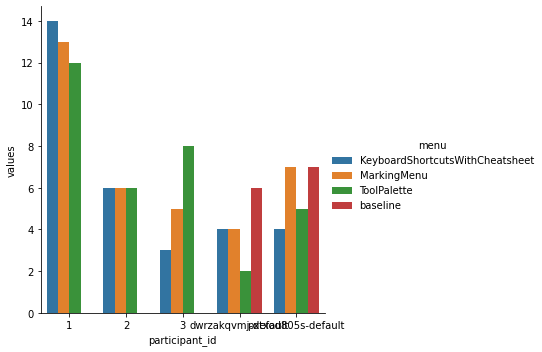

In [132]:
sns.catplot(data=unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index(), kind="bar", x='participant_id', y='values', hue='menu')

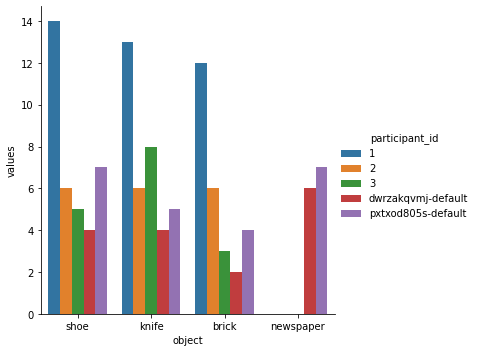

In [133]:
sns.catplot(data=unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index(), kind="bar", x='object', y='values', hue='participant_id')

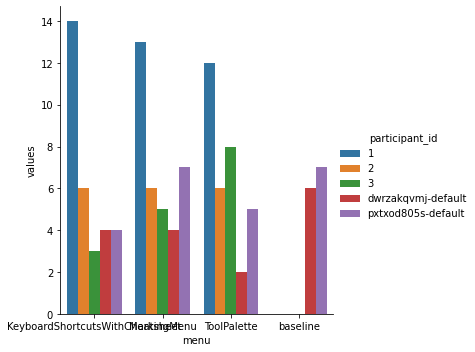

In [134]:
sns.catplot(data=unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index(), kind="bar", x='menu', y='values', hue='participant_id')

In [135]:
unusual_uses.groupby(['participant_id','menu','object']).count()

values  topTwo
participant_id     menu                            object                   
1                  KeyboardShortcutsWithCheatsheet shoe           14      14
                   MarkingMenu                     knife          13      13
                   ToolPalette                     brick          12      12
2                  KeyboardShortcutsWithCheatsheet brick           6       6
                   MarkingMenu                     shoe            6       6
                   ToolPalette                     knife           6       6
3                  KeyboardShortcutsWithCheatsheet brick           3       3
                   MarkingMenu                     shoe            5       5
                   ToolPalette                     knife           8       8
dwrzakqvmj-default KeyboardShortcutsWithCheatsheet knife           4       4
                   MarkingMenu                     shoe            4       4
                   ToolPalette                     brick           2       2
                   baseline                        newspaper       6       6
pxtxod805s-default KeyboardShortcutsWithCheatsheet brick           4       4
                   MarkingMenu                     newspaper       7       7
                   ToolPalette                     knife           5       5
                   baseline                        shoe            7       7

In [155]:
tlx = df[df['task'] == 'NasaTlx']


def extract_tlx(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)
    
    for log in row['logs']:
        if log['type'] == 'NasaTlx':
            return pd.Series(log['responses'])
tlx = pd.concat([tlx, tlx.apply(extract_tlx, axis=1)], axis=1)

metrics = 'Mental Demand	Physical Demand	Temporal Demand	Performance	Effort	Frustration'.split('	')

melted_tlx = pd.melt(tlx, id_vars=list(set(tlx.columns) - set(metrics)), value_vars=metrics)

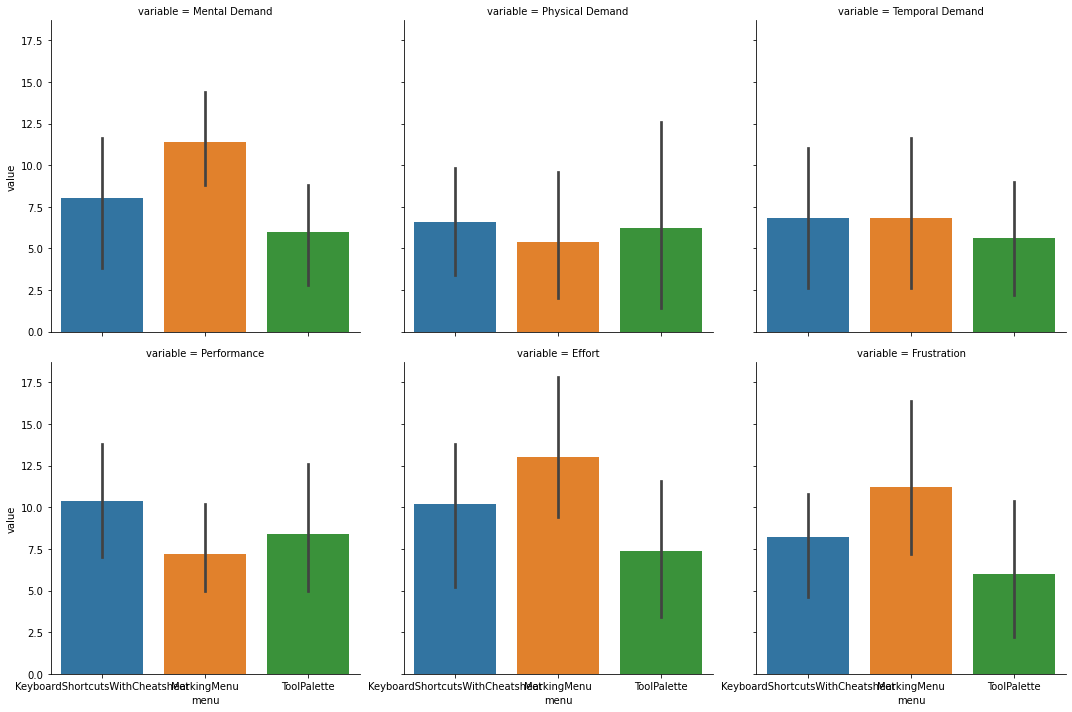

In [159]:
sns.catplot(data=melted_tlx, kind="bar", x='menu', y='value', col="variable", col_wrap=3)


# for metric in metrics:
#     display(Markdown(f'### {metric}'))
#     sns.catplot(data=tlx, kind="bar", x='menu', y=metric)
# #     sns.catplot(data=tlx, kind="bar", x='participant_id', y=metric, hue='menu')

In [145]:
questionnaire = df[df['task'] == 'Questionnaire']

def extract_questionnaire(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)

    for log in row['logs']:
        if log['type'] == 'QuestionnaireResponses':
            return pd.Series(log['responses'])
        
questionnaire = pd.concat([questionnaire, questionnaire.apply(extract_questionnaire, axis=1)], axis=1)
questionnaire['felt'] = questionnaire['I felt creative while I was selecting commands.']
questionnaire['use'] = questionnaire['I would like to use that command selection technique while doing a creative task like drawing or writing a story.']



In [146]:
questionnaire

,participant_id,metadata,tasks,DevTools,__INDEX__,participant_number,task,content,logs,menu,...,sizeScreenH,sizeScreenW,study_id,I felt creative while I was selecting commands.,I would like to use that command selection technique while doing a creative task like drawing or writing a story.,"Using a keyboard shortcuts within a content creation tool (drawing, writing, etc.) would help me be creative.","Using a marking menu within a content creation tool (drawing, writing, etc.) would help me be creative.","Using a tool palette within a content creation tool (drawing, writing, etc.) would help me be creative.",felt,use
33,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[1, 4]",0,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675111278196}...",KeyboardShortcutsWithCheatsheet,...,NaN,NaN,NaN,8.0,77.0,NaN,NaN,NaN,8.0,77.0
67,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[2, 4]",0,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675111808635}...",MarkingMenu,...,NaN,NaN,NaN,45.0,55.0,NaN,NaN,NaN,45.0,55.0
101,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[3, 4]",0,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675112181930}...",ToolPalette,...,NaN,NaN,NaN,25.0,0.0,NaN,NaN,NaN,25.0,0.0
138,2,"{""git_commit"":""3f9b2cc710a4b9cb4620695eaf653e7...","[""ProgressBar"",""DevTools""]","{""showInProduction"":true}","[1, 4]",1,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675107524570}...",ToolPalette,...,NaN,NaN,NaN,30.0,47.0,NaN,NaN,NaN,30.0,47.0
172,2,"{""git_commit"":""3f9b2cc710a4b9cb4620695eaf653e7...","[""ProgressBar"",""DevTools""]","{""showInProduction"":true}","[2, 4]",1,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675107779810}...",MarkingMenu,...,NaN,NaN,NaN,35.0,60.0,NaN,NaN,NaN,35.0,60.0
206,2,"{""git_commit"":""3f9b2cc710a4b9cb4620695eaf653e7...","[""ProgressBar"",""DevTools""]","{""showInProduction"":true}","[3, 4]",1,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675107947549}...",KeyboardShortcutsWithCheatsheet,...,NaN,NaN,NaN,19.0,25.0,NaN,NaN,NaN,19.0,25.0
243,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[1, 4]",2,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675122594372}...",ToolPalette,...,NaN,NaN,NaN,0.0,25.0,NaN,NaN,NaN,0.0,25.0
277,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[2, 4]",2,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675122943184}...",KeyboardShortcutsWithCheatsheet,...,NaN,NaN,NaN,4.0,10.0,NaN,NaN,NaN,4.0,10.0
311,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[3, 4]",2,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675123441446}...",MarkingMenu,...,NaN,NaN,NaN,34.0,0.0,NaN,NaN,NaN,34.0,0.0
422,dwrzakqvmj-default,"{""participant"":""dwrzakqvmj-default"",""WORKER_ID...","[""ProgressBar"",""ResolutionChecker""]",NaN,"[4, 4]",3,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675827719849}...",KeyboardShortcutsWithCheatsheet,...,1440.0,2560.0,unknown,70.0,NaN,90.0,NaN,NaN,70.0,NaN


## I felt creative while I was selecting commands.

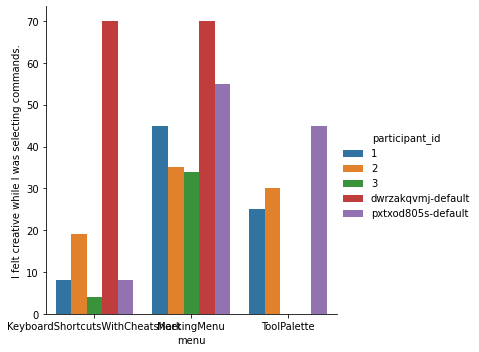

In [147]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='I felt creative while I was selecting commands.', hue='participant_id')

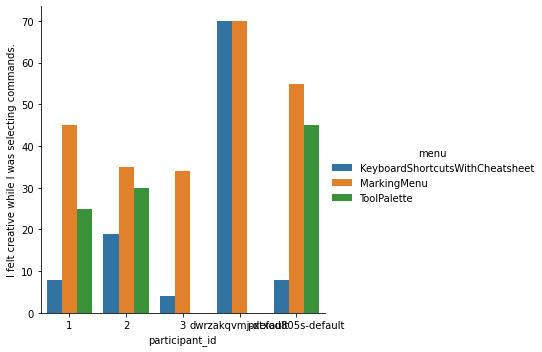

In [148]:
sns.catplot(data=questionnaire, kind="bar", x='participant_id', y='I felt creative while I was selecting commands.', hue='menu')

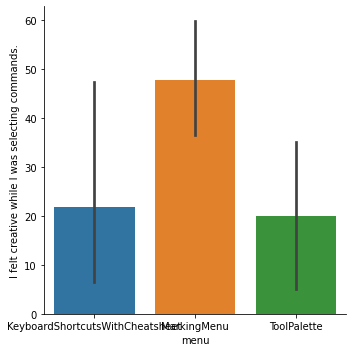

In [151]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='I felt creative while I was selecting commands.')

## I would like to use that command selection technique while doing a creative task like drawing or writing a story.

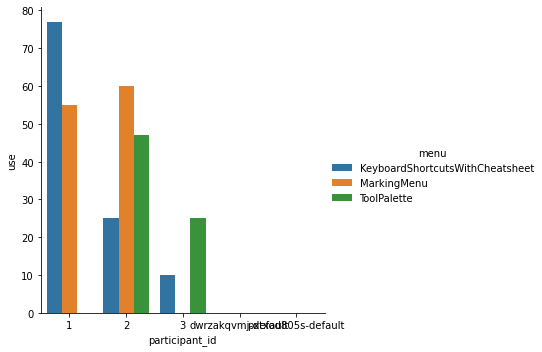

In [149]:
sns.catplot(data=questionnaire, kind="bar", x='participant_id', y='use', hue='menu')

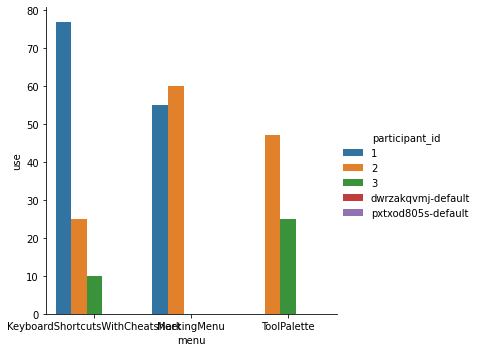

In [150]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='use', hue='participant_id')